# TFM. Deep Visin applied to Real state.

- Tensorflow-GPU on Colab => https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd
- Why using GPU for Deep Learning => https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d


Developer stuff:
- https://github.com/users/albertovpd/projects/8
- https://github.com/albertovpd/viu-fundamentos_redes_neuronales/tree/main/colabs/tasks
- https://github.com/albertovpd/viu-fundamentos_redes_neuronales/blob/main/colabs/clase_2y3-Introduccion_a_Deep_Learning_Colab_ipynb.ipynb

- https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e
- https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [2]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras import Model

# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50



from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


- base directory

In [3]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides	output
input								src


In [4]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# load pickling data allocated in Drive

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile
import pickle
%matplotlib inline

In [68]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x = pickle.load(input_file)
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- some preview

In [69]:
from collections import Counter
print(Counter(data_y))

Counter({'Livingroom': 1273, 'Bedroom': 1248, 'Dinning': 1158, 'Kitchen': 965, 'Bathroom': 606})


In [76]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [24]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

pics shape:  (5250, 128, 128, 3) 
number of classes:  5


Dinning


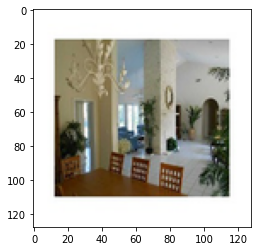

In [25]:
# showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- we have to transform y-label into numeric

In [26]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [27]:
#train_ratio = 0.7
#validation_ratio = 0.15
#test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

0.7 0.15 0.15


In [28]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

train:   (3675, 128, 128, 3) (3675, 5) 
test:  (788, 128, 128, 3) (788, 5) 
val:   (787, 128, 128, 3) (787, 5)


# Step 1. Pretrained NN performance.

- Basic NN start:
    - Alexnet
    - ResNet
    - SqueezeNet
    - EfficientNet
    - any other I think it could be great
    - vgg19
    

## VVG19

In [65]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19
base_model_vgg = VGG19(include_top = False, weights = 'imagenet', input_shape = (128,128,3), 
                       classes= y_train.shape[1]) 
##base_model_vgg.summary()

- transfer learning

In [66]:
base_model_vgg.trainable = False  

pre_trained_model_vgg = Sequential()
pre_trained_model_vgg.add(base_model_vgg)
pre_trained_model_vgg.add(layers.Flatten())
pre_trained_model_vgg.add(Dense(1024,activation=('relu'),input_dim=512))
pre_trained_model_vgg.add(Dense(512,activation=('relu'))) 
pre_trained_model_vgg.add(Dense(256,activation=('relu'))) 
pre_trained_model_vgg.add(Dropout(.2))
pre_trained_model_vgg.add(Dense(128,activation=('relu')))
pre_trained_model_vgg.add(Dense(64,activation=('relu')))
pre_trained_model_vgg.add(Dropout(.2))
pre_trained_model_vgg.add(Dense(16,activation=('relu'))) # binary
pre_trained_model_vgg.add(Dropout(.3))
pre_trained_model_vgg.add(Dense(5,activation=('softmax'))) # is used as the activation function in the output layer of neural network models that predict a multinomial probability distribution.
 
#Checking the final model summary
pre_trained_model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

- training

In [79]:
#Learning Rate Annealer 
# The learning rate annealer decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, 
#we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
lra= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
number_eps = 100
#Compilamos el modelo
pre_trained_model_vgg.compile(loss = "categorical_crossentropy", 
                              optimizer = Adam(learning_rate = 3e-4 , decay=0, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08), 
                              metrics = ["accuracy"]) #lr = 0.0005

#Entrenamiento
mira bien el flag de validation_split, que estás pre-spliteando antes cabesa
vgg_pre = pre_trained_model_vgg.fit(x_train, y_train, batch_size=128, epochs=number_eps, validation_split=0.2) 
# for data augmentation model.fit_generator(train_generator.flow(x_train, y_train, batch_siz e= batch_size),epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), validation_steps = 250, callbacks=[lrr], verbose = 1)

#Guardar modelo
pre_trained_model_vgg.save(output_folder+"deepCNN_vgg_1.h5")

#Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = pre_trained_model_vgg.predict(x_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = classes_list))


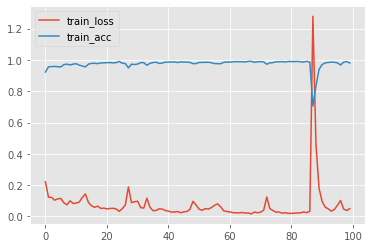

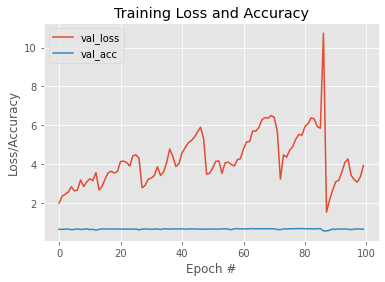

In [83]:
number_eps = 100
#Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, number_eps), vgg_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, number_eps), vgg_pre.history["accuracy"], label="train_acc")
plt.legend()
plt.show()
plt.plot(np.arange(0, number_eps), vgg_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, number_eps), vgg_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
mete la confusion matrix de las clases que siempre mola https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/

- data augmentation for the same architecture